In [1]:
import sys
sys.path.append("../dwaveutils/dwavetools")
sys.path.append("../dwaveutils/probrep")
from dictrep import DictRep
from dwavetools import (find_heff_s, make_dwave_schedule, create_heff_csv,
                        nqubit_1pauli, nqubit_2pauli, loadAandB,
                        make_numeric_schedule, time_interpolation,
                        get_numeric_H)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qutip as qt
from dwave.system.samplers import DWaveSampler
import networkx as nx
import dwave_networkx as dnx
from math import floor

First, let's set-up a 1-D Ising chain with PBC s.t. N = 6 = $N_S$ + $N_E$. $N_S$ = 2 and $N_E$ = 4.

In [2]:
Hz = {(0, 0): 'hE1', (1, 1): 'hE1', (2, 2): 'hS1', (3, 3): 'hS2', (4, 4): 'hE1', (5, 5): 'hE1',\
      (0, 1): 'JE1', (1, 2): 'JE2', (2, 3): 'JS1', (3, 4): 'JE3', (4, 5): 'JE4', (0, 5): 'JE5'}
Hzprob = DictRep(Hz, 'dwave', 'ising', 'logical')

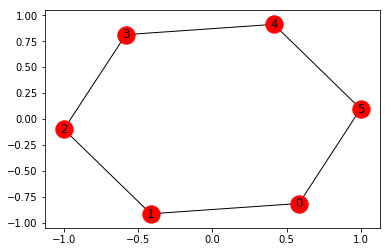

In [3]:
Hzprob.visualize_graph()

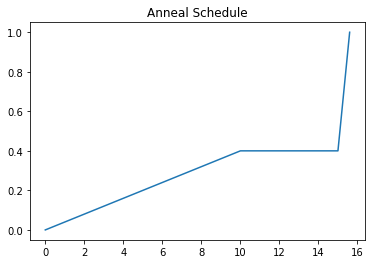

In [4]:
ta, sa, tp, tq = 10, 0.4, 5, 0.6
T = ta + tp + tq
schedule = make_numeric_schedule(.1, **{'ta': ta, 'sa': sa, 'tp': tp, 'tq': tq})
times = schedule[0]
svals = schedule[1]

plt.plot(times, svals)
plt.title("Anneal Schedule")
plt.show()

In [5]:
sampler = DWaveSampler()
G = nx.Graph()
wqubits = sampler.properties['qubits']
wcouplers = sampler.properties['couplers']
chipdata = {'wqubits': wqubits, 'wcouplers': wcouplers}

In [6]:
G.add_edges_from(sampler.properties['couplers'])

In [7]:
qubitlist = [q for q in range(0, 8) if q in sampler.properties['qubits']]

In [8]:
H = nx.Graph()
H.add_edges_from(G.subgraph(qubitlist).edges())
H.edges()

EdgeView([(0, 4), (0, 5), (0, 6), (0, 7), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3), (6, 1), (6, 2), (6, 3), (7, 1), (7, 2), (7, 3)])

In [9]:
paths = nx.all_simple_paths(H, 0, 7)
node_path = max(paths, key=len)
best_path = []
for i in range(len(node_path)-1):
    best_path.append((node_path[i], node_path[i+1]))
best_graph = nx.Graph()
best_graph.add_edges_from(best_path)

In [10]:
unit_cell = dnx.chimera_graph(1, 1)
colors = []
for u, v in H.edges():
    if (u, v) in best_path or (v, u) in best_path: 
        colors.append('blue')
    else:
        colors.append('black')

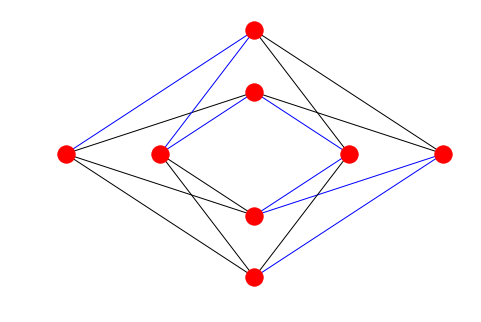

In [11]:
dnx.draw_chimera(H, edge_color = colors)

In [12]:
def dense_connect_2000Q(chipdata, qi, R, C, hval, Jval):
    '''
    Takes in the "chipdata" as a dictionary that contains working qubits and couplers and 
    finds (if possible) the longest unbroken chain connecting q1 to q2.
    
    chipdata: {'wqubits': [q1, q2, ...], 'couplers' [[q1, q2], [q2, q3]...]}
    qi: integer specifiying lowest # qubit (initial) being connected
    R: integer specifying how many rows to chain including q1 row
    C: interger specifying how many columns to chain including q1 column
    '''
    dictH = {}
    # pre-processing steps
    # --------------------------
    # for the 2000Q, the following parameters can be used
    ucsize, rows, columns = 8, 16, 16
    wqubits = chipdata['wqubits']
    wcouplers = chipdata['wcouplers']
    G = nx.Graph()
    G.add_edges_from(wcouplers)
    # first, check that qi is actually in the graph
    if qi not in wqubits:
        return("Error: qi is not in the list of working qubits for this graph.")
    # compute initial and final unit cells
    ui = floor(qi/ucsize)
    uf = ((columns)-ui)*(R-1) + ui + (C-1)
    # print out the unit cells trying to be connected for users 
    print("Going to try and connect unit cell {} with unit cell {}".format(ui, uf))
    # now, ensure ui and uf can, in fact, be connected
    connections = 0
    for q in range(uf*8, uf*8 + 7):
        try:
            nx.shortest_path(G, qi, q)
            connections += 1
            break
        except:
            continue
    if connections == 0:
        return("There are no paths that connect unit cell {} with unit cell {}.".format(ui, uf)) 
    
    # densely connect within unit cells and "heuristically" connect adjacent cells
    # aka try sensical connections and ensure connected afterwards
    for row in range(0, R):
        # find the first and last unit cell in this column
        uci = ui + row*columns
        ucf = uci + (C-1)
        # iterate to last unit cell
        for uc in range(uci, ucf+1):
            # find working qubits in uc
            ucq = [q + uc*8 for q in range(8)]
            working_ucq = [q for q in ucq if q in wqubits]
            qi = min(working_ucq)
            qf = max(working_ucq)
                               
            # create a unit cell subgraph and find longest chain by exhaustive enumeration
            ucG = nx.Graph()
            ucG.add_edges_from(G.subgraph(working_ucq).edges())
            paths = nx.all_simple_paths(ucG, qi, qf)
            node_path = max(paths, key=len)
            dictH.update({(q, q): hval for q in node_path})
            best_path = []
            for i in range(len(node_path)-1):
                best_path.append((node_path[i], node_path[i+1]))
            dictH.update({key: Jval for key in best_path})
            
            # connect uc to neighbor to the right
            used_rqubits = []
            if uc != ucf:
                # get the qubits that connect to the right
                rqubits = [q for q in working_ucq if q % 8 > 3]
                for q in rqubits:
                    if [q, q+8] in wcouplers:
                        dictH.update({(q, q+8): Jval, (q, q): hval})
                        used_rqubits.append(q)
                        
                if not any(q in node_path for q in rqubits):
                    return("Heuristic chaining failed. There are no inter-unit cell connections" +
                    " between uc {} and {}".format(uc, uc+1))
                        
            # connect uc to neighbor down below
            used_dqubits = []
            if row != (R-1):
                # get the qubits that connect down
                dqubits = [q for q in working_ucq if q % 8 <= 3]
                for q in dqubits:
                    if [q, q+128] in wcouplers:
                        dictH.update({(q, q+128): Jval, (q, q): hval})
                        used_dqubits.append(q)
                        
                if not any(q in node_path for q in dqubits):
                    return("Heuristic chaining failed. There are no inter-unit cell connections" +
                    " between uc {} and {}".format(uc, uc+16))
                
    qubits_used = len([(key, value) for key, value in dictH if key == value])
    print("Successfully created a dense chain with {} qubits.".format(qubits_used))
            
    return dictH

In [13]:
dictH = dense_connect_2000Q(chipdata, 0, 1, 3, 'h', 'J')

Going to try and connect unit cell 0 with unit cell 2
Successfully created a dense chain with 24 qubits.


In [14]:
couplers = [(key, value) for key, value in dictH if key != value]

In [15]:
g = nx.Graph()
g.add_edges_from(couplers)
nx.write_gexf(g, "test.gexf")

In [16]:
g.edges()

EdgeView([(0, 4), (4, 1), (4, 12), (1, 5), (5, 2), (5, 13), (2, 6), (6, 3), (6, 14), (3, 7), (7, 15), (12, 8), (12, 9), (12, 20), (13, 9), (13, 10), (13, 21), (14, 10), (14, 11), (14, 22), (15, 11), (15, 23), (20, 16), (20, 17), (21, 17), (21, 18), (22, 18), (22, 19), (23, 19)])

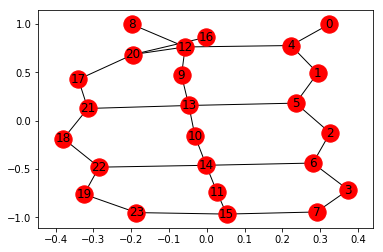

In [17]:
nx.draw_networkx(g)